# 2A.ml - Analyse de sentiments - correction

C'est désormais un problème classique de machine learning. D'un côté, du texte, de l'autre une appréciation, le plus souvent binaire, positive ou négative mais qui pourrait être graduelle.

In [1]:
%matplotlib inline

In [2]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Les données

On récupère les données depuis le site UCI [Sentiment Labelled Sentences Data Set](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences) où on utilise la fonction ``load_sentiment_dataset``.

In [3]:
from ensae_teaching_cs.data import load_sentiment_dataset
df = load_sentiment_dataset()
df.head()

,sentance,sentiment,source
0,So there is no way for me to plug it in here i...,0,amazon_cells_labelled
1,"Good case, Excellent value.",1,amazon_cells_labelled
2,Great for the jawbone.,1,amazon_cells_labelled
3,Tied to charger for conversations lasting more...,0,amazon_cells_labelled
4,The mic is great.,1,amazon_cells_labelled


## Exercice 1 : approche td-idf

La cible est la colonne *sentiment*, les deux autres colonnes sont les features. Il faudra utiliser les prétraitements [LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html), [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), [TF-IDF](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). L'un d'entre eux n'est pas nécessaire depuis la version [0.20.0](http://scikit-learn.org/stable/whats_new.html#sklearn-preprocessing) de *scikit-learn*. On s'occupe des variables catégorielles.

### La variable catégorielle

Ce serait un peu plus simple avec le module [Category Encoders](http://contrib.scikit-learn.org/categorical-encoding/) ou la dernière nouveauté de scikit-learn : [ColumnTransformer](http://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer).

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
                df.drop("sentiment", axis=1), df["sentiment"])

In [5]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()
le.fit(X_train["source"])
X_le = le.transform(X_train["source"])
X_le.shape

(2250,)

In [6]:
X_le_mat = X_le.reshape((X_le.shape[0], 1))

In [7]:
ohe = OneHotEncoder(categories="auto")
ohe.fit(X_le_mat)

OneHotEncoder(categorical_features=None, categories='auto',
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=True)

In [8]:
X_le_encoded = ohe.transform(X_le_mat)
train_cat = X_le_encoded.todense()
test_cat = ohe.transform(le.transform(X_test["source"]).reshape((len(X_test), 1))).todense()

In [9]:
import pandas
X_train2 = pandas.concat([X_train.reset_index(drop=True),
                          pandas.DataFrame(train_cat, columns=le.classes_)],
                         sort=False, axis=1)
X_train2.head(n=2)

,sentance,source,amazon_cells_labelled,imdb_labelled,yelp_labelled
0,"Good service, very clean, and inexpensive, to ...",yelp_labelled,0.0,0.0,1.0
1,"On the negative, it's insipid enough to cause ...",imdb_labelled,0.0,1.0,0.0


In [10]:
X_test2 = pandas.concat([X_test.reset_index(drop=True),
                         pandas.DataFrame(test_cat, columns=le.classes_)],
                         sort=False, axis=1)
X_test2.head(n=2)

,sentance,source,amazon_cells_labelled,imdb_labelled,yelp_labelled
0,We are so glad we found this place.,yelp_labelled,0.0,0.0,1.0
1,I was disgusted because I was pretty sure that...,yelp_labelled,0.0,0.0,1.0


### tokenisation

On tokenise avec le module [spacy](https://spacy.io/usage/spacy-101#annotations-token) qui requiert des données supplémentaires pour découper en mot avec ``pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.0.0/en_core_web_sm-2.0.0.tar.gz`` selon les instructions dévoilées dans le [guide de départ](https://spacy.io/usage/models) ou encore ``python -m spacy download en``. Le module [gensim](http://www.xavierdupre.fr/app/papierstat/helpsphinx/notebooks/artificiel_tokenize.html?highlight=tokenisation#gensim) ne requiert pas d'installation. On peut aussi s'inspirer de l'example [word2vec pré-entraînés](http://www.xavierdupre.fr/app/papierstat/helpsphinx/notebooks/text_sentiment_wordvec.html#word2vec-pre-entraines).

In [11]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [12]:
doc = nlp(X_train2.iloc[0,0])
[token.text for token in doc]

['Good',
 'service',
 ',',
 'very',
 'clean',
 ',',
 'and',
 'inexpensive',
 ',',
 'to',
 'boot',
 '!']

### tf-idf

Une fois que les mots sont tokenisé, on peut appliquer le *tf-idf*.

In [13]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.pipeline import make_pipeline
tokenizer = lambda text: [token.text.lower() for token in nlp(text)]
count = CountVectorizer(tokenizer=tokenizer, analyzer='word')
tfidf = TfidfTransformer()
pipe = make_pipeline(count, tfidf)

In [14]:
pipe.fit(X_train["sentance"])

Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
  ...'tfidftransformer', TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True))])

In [15]:
train_feature = pipe.transform(X_train2["sentance"])
train_feature

<2250x4478 sparse matrix of type '<class 'numpy.float64'>'
	with 29454 stored elements in Compressed Sparse Row format>

In [16]:
test_feature = pipe.transform(X_test2["sentance"])

### Combinaison de toutes les variables

In [17]:
train_feature.shape, train_cat.shape

((2250, 4478), (2250, 3))

In [18]:
import numpy
np_train = numpy.hstack([train_feature.todense(), train_cat])
np_test = numpy.hstack([test_feature.todense(), test_cat])

### Calage d'un modèle

In [19]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=50)
rf.fit(np_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [20]:
rf.score(np_test, y_test)

0.7666666666666667

## Exercice 2 : word2vec

On utilise l'approche [word2vec](https://en.wikipedia.org/wiki/Word2vec) du module [gensim](https://radimrehurek.com/gensim/models/word2vec.html) ou [spacy](https://spacy.io/usage/vectors-similarity). Avec [spacy](https://spacy.io/usage/vectors-similarity), c'est assez simple :

In [22]:
vv = nlp(X_train2.iloc[0, 0])
list(vv)[0].vector[:10], vv.vector.shape

(array([-0.9418167, -0.6240454, -1.9665407,  1.670512 , -2.573586 ,
         1.4199752,  1.7455809,  1.2713523, -2.0450075,  0.5746417],
       dtype=float32), (384,))

On fait la somme.

In [23]:
sum([_.vector for _ in vv])[:10]

array([ 9.052872  , -2.0875132 , -3.35144   ,  0.08118324, -9.124436  ,
       13.140404  , -8.524071  ,  3.6326594 , 11.44552   ,  5.305859  ],
      dtype=float32)

In [24]:
np_train_vect = numpy.zeros((X_train2.shape[0], vv.vector.shape[0]))
for i, sentance in enumerate(X_train2["sentance"]):
    np_train_vect[i, :] = sum(v.vector for v in nlp(sentance.lower()))

In [25]:
np_test_vect = numpy.zeros((X_test2.shape[0], vv.vector.shape[0]))
for i, sentance in enumerate(X_test2["sentance"]):
    np_test_vect[i, :] = sum(v.vector for v in nlp(sentance.lower()))

In [26]:
np_train_v = numpy.hstack([np_train_vect, train_cat])
np_test_v = numpy.hstack([np_test_vect, test_cat])

In [27]:
rfv = RandomForestClassifier(n_estimators=50)
rfv.fit(np_train_v, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [28]:
rfv.score(np_test_v, y_test)

0.6453333333333333

Moins bien...

## Exercice 3 : comparer les deux approches

Avec une courbe [ROC](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) par exemple.

In [29]:
pmodel1 = rf.predict_proba(np_test)[:, 1]
pmodel2 = rfv.predict_proba(np_test_v)[:, 1]

In [30]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
fpr1, tpr1, th1 = roc_curve(y_test, pmodel1)
fpr2, tpr2, th2 = roc_curve(y_test, pmodel2)

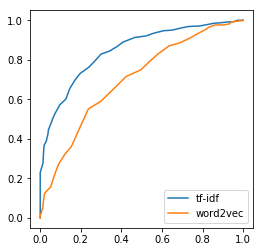

In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.plot(fpr1, tpr1, label='tf-idf')
ax.plot(fpr2, tpr2, label='word2vec')
ax.legend();

## Petite analyse d'erreurs

On combine les erreurs des modèles sur la base de test.

In [32]:
final = X_test.copy()
final["model1"] = pmodel1
final["model2"] = pmodel2
final["label"] = y_test
final.head()

,sentance,source,model1,model2,label
64,We are so glad we found this place.,yelp_labelled,0.70,0.66,1
14,I was disgusted because I was pretty sure that...,yelp_labelled,0.26,0.42,0
279,I had the mac salad and it was pretty bland so...,yelp_labelled,0.22,0.18,0
935,"It never condescends, all the characters have ...",imdb_labelled,0.76,0.58,1
188,Nothing at all to recommend.,imdb_labelled,0.38,0.34,0


On regarde des erreurs.

In [33]:
erreurs = final[final["label"] == 1].sort_values("model2")
erreurs.head()

,sentance,source,model1,model2,label
632,I did not have any problem with this item and ...,amazon_cells_labelled,0.26,0.10,1
32,I found this place by accident and I could not...,yelp_labelled,0.18,0.16,1
271,You cant go wrong with any of the food here.,yelp_labelled,0.38,0.20,1
755,"When I'm on this side of town, this will defin...",yelp_labelled,0.50,0.22,1
50,I'm glad the film didn't go for the most obvio...,imdb_labelled,0.10,0.22,1


In [34]:
list(erreurs["sentance"])[:5]

['I did not have any problem with this item and would order it again if needed.',
 'I found this place by accident and I could not be happier.',
 'You cant go wrong with any of the food here.',
 "When I'm on this side of town, this will definitely be a spot I'll hit up again!",
 "I'm glad the film didn't go for the most obvious choice, as a lesser film certainly would have.  "]

Le modèle 2 reconnaît mal les négations visiblement. On regarde le modèle 1.

In [35]:
erreurs = final[final["label"] == 1].sort_values("model1")
erreurs.head()

,sentance,source,model1,model2,label
50,I'm glad the film didn't go for the most obvio...,imdb_labelled,0.10,0.22,1
604,Couldn't ask for a more satisfying meal.,yelp_labelled,0.10,0.30,1
436,"The soundtrack wasn't terrible, either.",imdb_labelled,0.10,0.30,1
449,"I won't say any more - I don't like spoilers, ...",imdb_labelled,0.14,0.42,1
545,"No shifting, no bubbling, no peeling, not even...",amazon_cells_labelled,0.16,0.34,1


In [36]:
list(erreurs["sentance"])[:5]

["I'm glad the film didn't go for the most obvious choice, as a lesser film certainly would have.  ",
 "Couldn't ask for a more satisfying meal.",
 "The soundtrack wasn't terrible, either.  ",
 "I won't say any more - I don't like spoilers, so I don't want to be one, but I believe this film is worth your time.  ",
 "No shifting, no bubbling, no peeling, not even a scratch, NOTHING!I couldn't be more happier with my new one for the Droid."]

Idem, voyons là où les modèles sont en désaccords.

In [37]:
final["diff"] = final.model1 - final.model2

In [38]:
erreurs = final[final["label"] == 1].sort_values("diff")
erreurs.head()

,sentance,source,model1,model2,label,diff
777,WORTHWHILE.,amazon_cells_labelled,0.22,0.58,1,-0.36
501,"I left the theater with a lilt in my step, joy...",imdb_labelled,0.38,0.68,1,-0.30
921,"Not much dialogue, not much music, the whole f...",imdb_labelled,0.26,0.56,1,-0.30
448,My 8/10 score is mostly for the plot.,imdb_labelled,0.20,0.50,1,-0.30
193,"I had a salad with the wings, and some ice cre...",yelp_labelled,0.34,0.64,1,-0.30


In [39]:
erreurs.tail()

,sentance,source,model1,model2,label,diff
887,Best headset ever!!!.,amazon_cells_labelled,0.90,0.48,1,0.42
895,I want to first say our server was great and w...,yelp_labelled,0.94,0.48,1,0.46
702,Have been going since 2007 and every meal has ...,yelp_labelled,0.84,0.36,1,0.48
473,Great software for Motorolas.,amazon_cells_labelled,0.98,0.50,1,0.48
375,Best tacos in town by far!!,yelp_labelled,0.92,0.42,1,0.50


Le modèle 2 (word2vec) a l'air meilleur sur les phrases longues, le modèle 1 (tf-idf) saisit mieux les mots positifs. A confirmer sur plus de données. 

* Enlever les stop words, les signes de ponctuation.
* Combiner les deux approches.
* n-grammes
* ...

Dernière analyse en regardant le taux d'erreur par source.

In [40]:
r1 = rf.predict(np_test)
r2 = rfv.predict(np_test_v)
final["rep1"] = r1
final["rep2"] = r2
final["err1"] = (final.label - final.rep1).abs()
final["err2"] = (final.label - final.rep2).abs()
final["total"] = 1
final.head()

,sentance,source,model1,model2,label,diff,rep1,rep2,err1,err2,total
64,We are so glad we found this place.,yelp_labelled,0.70,0.66,1,0.04,1,1,0,0,1
14,I was disgusted because I was pretty sure that...,yelp_labelled,0.26,0.42,0,-0.16,0,0,0,0,1
279,I had the mac salad and it was pretty bland so...,yelp_labelled,0.22,0.18,0,0.04,0,0,0,0,1
935,"It never condescends, all the characters have ...",imdb_labelled,0.76,0.58,1,0.18,1,1,0,0,1
188,Nothing at all to recommend.,imdb_labelled,0.38,0.34,0,0.04,0,0,0,0,1


In [41]:
final[["source", "err1", "err2", "total"]].groupby("source").sum()

,err1,err2,total
source,,,
amazon_cells_labelled,47,75,237
imdb_labelled,75,103,270
yelp_labelled,53,88,243


*imdb* paraît une source une peu plus difficile à saisir. Quoiqu'il en soit, 2000 phrases pour apprendre est assez peu pour apprendre.

## Versions utilisées pour ce notebook

[spacy](https://spacy.io/) s'est montré quelque peu fantasques cette année avec quelques erreurs notamment celle-ci :
[ValueError: cymem.cymem.Pool has the wrong size, try recompiling](https://github.com/explosion/spaCy/issues/2852). Voici les versions utilisées...

In [42]:
def version(module, sub=True):
    ver = getattr(module, '__version__', None)
    if ver is None:
        ver = [_ for _ in os.listdir(os.path.join(module.__file__, '..', '..' if sub else '')) \
               if module.__name__ in _ and 'dist' in _][-1]
    return ver

In [43]:
import os
import thinc
print("thinc", version(thinc))
import preshed
print("preshed", version(preshed))
import cymem
print("cymem", version(cymem))
import murmurhash
print("murmurhash", version(murmurhash))
import plac
print("plac", plac.__version__)
import spacy
print("spacy", spacy.__version__)

import en_core_web_sm
print("en_core_web_sm", en_core_web_sm.__version__)
import fr_core_news_sm
print("fr_core_news_sm", fr_core_news_sm.__version__)
import msgpack
print("msgpack", version(msgpack))
import msgpack_numpy
print("msgpack_numpy", version(msgpack_numpy, False))
import numpy
print("numpy", numpy.__version__)

thinc thinc-6.12.1.dist-info
preshed preshed-2.0.1.dist-info
cymem cymem-2.0.2.dist-info
murmurhash murmurhash-1.0.1.dist-info
plac 0.9.6
spacy 2.0.18
en_core_web_sm 2.0.0
fr_core_news_sm 2.0.0
msgpack msgpack_python-0.5.6.dist-info
msgpack_numpy msgpack_numpy-0.4.4.2.dist-info
numpy 1.16.1
